# March 31, 2025

COSI 104-A Learning over Images

Here, we will demonstrate how one of our models can learn to classify images over a simple, bitmap representation.

This notebook is largely based on an SKlearn example found at https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html.


In [127]:

# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split


First, we load the digits dataset.  It contains 1800 8x8 bitmaps of hand drawn digits.  This means each sample is a 64-dimensional vector.

(1797, 8, 8)


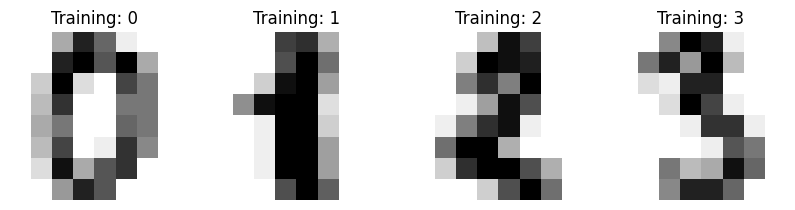

In [128]:
digits = datasets.load_digits()
print(digits.images.shape)

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


First, we do some slight preprocessing - the original data space is flattened from 8x8 to 64x1 (i.e. from a matrix to a vector, essentially laying out each row of the image next to the previous one).  Then, an out-of-the-box Support Vector Machine Classifier is trained on half the images and tested on the other half.


In [129]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))
print("shape is ", data.shape)
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)


shape is  (1797, 64)


The first four examples of the testing set are shown, with their predicted class.

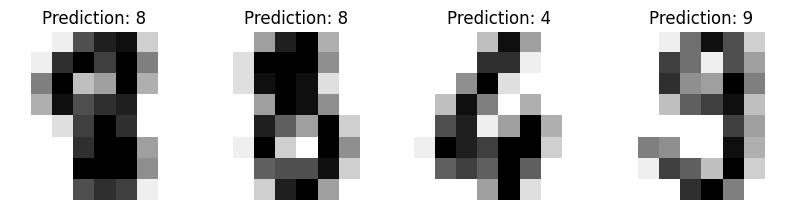

In [130]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    image = image.reshape(8, 8)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}")

Lastly, we print a confusion matrix.  Overall the model gets an accuracy in the 80s.

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


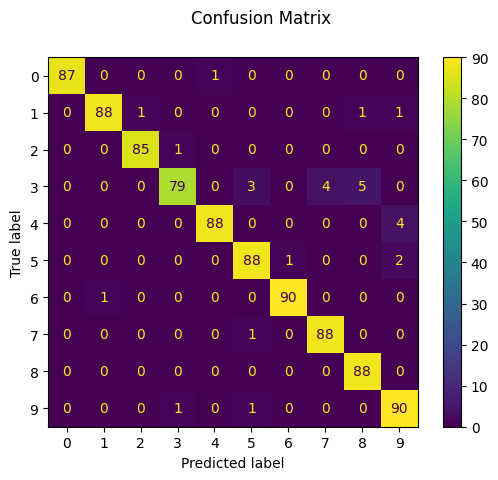

In [131]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()


## Evaluating performance

Overall, the SVM did pretty well!  We probably need to squeeze some higher performance out of it - imagine if your mail sorting got your zip code digits wrong 10% of the time - there'd be less than a 50% chance of it recognizing your whole zip code.

We can try to find a better representation for the problem by reducing the dimensionality.

In [132]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=16).fit(X_train)

X_transform_train = sklearn_pca.transform(X_train)
X_transform_test = sklearn_pca.transform(X_test)

# Create a classifier: a support vector classifier
clf_low_dim = svm.SVC(gamma=0.001)

# Learn the digits on the train subset in the lower dimensional space
clf_low_dim.fit(X_transform_train, y_train)

# Predict the value of the digit on the test subset
transformed_predicted = clf_low_dim.predict(X_transform_test)

Confusion matrix:
[[87  0  0  0  1  0  0  0  0  0]
 [ 0 88  1  0  0  0  0  0  1  1]
 [ 0  0 85  1  0  0  0  0  0  0]
 [ 0  0  0 79  0  3  0  4  5  0]
 [ 0  0  0  0 88  0  0  0  0  4]
 [ 0  0  0  0  0 88  1  0  0  2]
 [ 0  1  0  0  0  0 90  0  0  0]
 [ 0  0  0  0  0  1  0 88  0  0]
 [ 0  0  0  0  0  0  0  0 88  0]
 [ 0  0  0  1  0  1  0  0  0 90]]


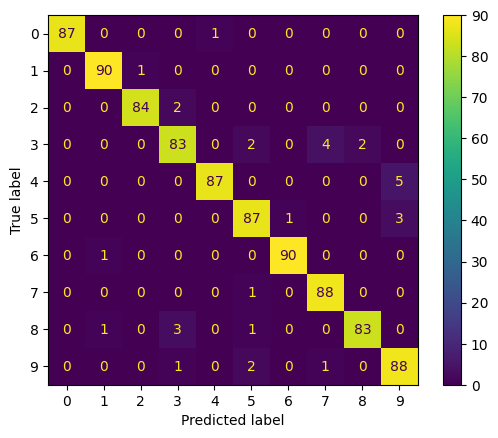

In [133]:
disp_transformed = metrics.ConfusionMatrixDisplay.from_predictions(y_test, transformed_predicted)
disp.figure_.suptitle("Confusion Matrix after DimRed")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

plt.show()


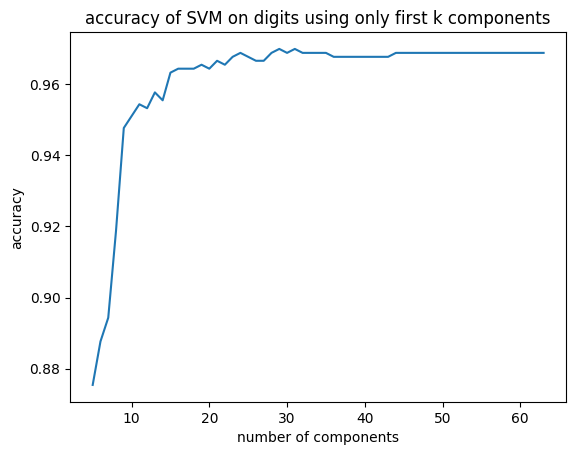

In [134]:
# Let's see the effect on performance as we change the dimensionality.
def train_and_predict_accuracy(n_components):
    sklearn_pca = PCA(n_components=n_components).fit(X_train)

    X_transform_train = sklearn_pca.transform(X_train)
    X_transform_test = sklearn_pca.transform(X_test)

    # Create a classifier: a support vector classifier
    clf_low_dim = svm.SVC(gamma=0.001)

    # Learn the digits on the train subset in the lower dimensional space
    clf_low_dim.fit(X_transform_train, y_train)

    # Predict the value of the digit on the test subset
    transformed_predicted = clf_low_dim.predict(X_transform_test)
    clf.fit(X_train, y_train)

    return metrics.accuracy_score(y_test, transformed_predicted)

components = range(5,64)
accs = [train_and_predict_accuracy(n) for n in components]

plt.title("accuracy of SVM on digits using only first k components")
plt.xlabel("number of components")
plt.ylabel("accuracy")
plt.plot(components, accs)


Decreasing the dimensionality didn't change the performance much, and in fact, lowering the number of components to 8 or 10 results in a pretty severe penalty in performance.  Let's try a different image dataset.

In [135]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [136]:
# flatten the images
n_samples = len(faces.images)
data = faces.images.reshape((n_samples, -1))
print(data.shape)
# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.001)

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, faces.target, test_size=0.5, shuffle=True
)

# Learn the digits on the train subset
clf.fit(X_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(X_test)


(400, 4096)


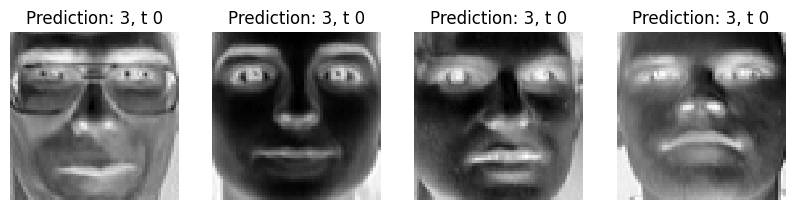

In [137]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
i=0
for ax, image, prediction in zip(axes, X_test, predicted):
    ax.set_axis_off()
    true_label = faces.target[i]
    image = image.reshape(64, 64)
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title(f"Prediction: {prediction}, t {true_label}")
    i+=1

In [138]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)


Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.01      1.00      0.02         2
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           7       1.00      0.67      0.80         3
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         8
          16       0.00   

/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [139]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components=64).fit(X_train)

X_transform_train = sklearn_pca.transform(X_train)
X_transform_test = sklearn_pca.transform(X_test)

# Create a classifier: a support vector classifier
clf_low_dim = svm.SVC(gamma=0.001)

# Learn the digits on the train subset in the lower dimensional space
clf_low_dim.fit(X_transform_train, y_train)

# Predict the value of the digit on the test subset
transformed_predicted = clf_low_dim.predict(X_transform_test)

In [140]:
print(
    f"Classification report for classifier {clf}:\n"
    f"{metrics.classification_report(y_test, predicted)}\n"
)


Classification report for classifier SVC(gamma=0.001):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         5
           3       0.01      1.00      0.02         2
           4       0.00      0.00      0.00         6
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00         5
           7       1.00      0.67      0.80         3
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         7
          11       0.00      0.00      0.00         5
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         8
          16       0.00   

/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dylancashman/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Here, we were only able to get 5% accuracy using SVM.  The dataset here was much larger (64x64, or 4096 dimensions), and there were actually 40 classes.  And dimensionality reduction didn't have much effect.

The problem we are facing here is that the data is probably lower dimensional, but we aren't able to find those dimensions using PCA.  Soon, we will learn about neural networks that find this improved representation as part of their learning process.

# Learning with PyTorch

We're going to try to use PyTorch to work on this classification problem.

First, let's follow the tutorial in https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [141]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


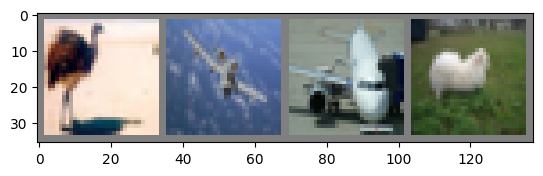

bird  plane plane dog  


In [142]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [143]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [144]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [145]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.202
[1,  4000] loss: 1.878
[1,  6000] loss: 1.683
[1,  8000] loss: 1.585
[1, 10000] loss: 1.493
[1, 12000] loss: 1.452
[2,  2000] loss: 1.387
[2,  4000] loss: 1.361
[2,  6000] loss: 1.317
[2,  8000] loss: 1.284
[2, 10000] loss: 1.277
[2, 12000] loss: 1.268
Finished Training


In [146]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


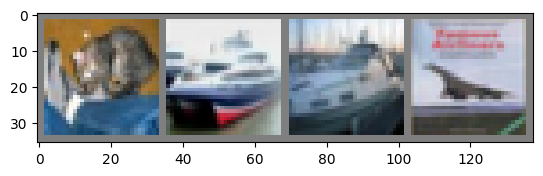

GroundTruth:  cat   ship  ship  plane


In [147]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [148]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [149]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


In [81]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 46.0 %
Accuracy for class: car   is 59.9 %
Accuracy for class: bird  is 42.0 %
Accuracy for class: cat   is 31.7 %
Accuracy for class: deer  is 31.7 %
Accuracy for class: dog   is 58.4 %
Accuracy for class: frog  is 80.0 %
Accuracy for class: horse is 57.2 %
Accuracy for class: ship  is 74.0 %
Accuracy for class: truck is 67.6 %


Pretty great!  With CIFAR, we have 10 distinct classes, and we have 1k images each.  We are able to predict at about 54\% accuracy, which is really good considering random guessing is 10\%.

The top CNNs are able to get [better than 99\% accuracy](https://paperswithcode.com/sota/image-classification-on-cifar-10).  We could definitely improve ours by making our network deeper and training for much longer.  There are a lot of different tricks that can be applied beyond that, even with simple architectures like ours, like preprocessing the data, augmenting our dataset with small rotations, reflections, and even discolored versions of our data.  However, let's see if we can adapt this well-known dataset to the Olivetti faces and do better than 5\% accuracy using CNNs.

In [150]:
# First, we need to change the data loader code to load the Olivetti faces instead of CIFAR.
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
olivetti = fetch_olivetti_faces()
data = olivetti.images  # shape (400, 64, 64) - grayscale images
targets = olivetti.target # shape (400,) - labels

# Convert to numpy arrays
images = np.array(data, dtype=np.float32)
labels = np.array(targets, dtype=np.int64)

# Shuffle the data
images, labels = shuffle(images, labels, random_state=42) # Consistent shuffle.

# Split into training and test sets
# Note that this dataset is really small, only 400 images, so I'm not going to do a full split,
# I will just take the last 10 images out for us to test for illustration purposes.
train_images = images[:-10]
train_labels = labels[:-10]
test_images = images[-10:]
test_labels = labels[-10:]


# Define a custom dataset class
class OlivettiFacesDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensor and add channel dimension (grayscale)
        image = torch.from_numpy(image).unsqueeze(0) # (1, 64, 64)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])

# Create the dataset and dataloader
train_dataset = OlivettiFacesDataset(train_images, train_labels, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = OlivettiFacesDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) #batch size 1 for easy printing.

# Sanity check to confirm the size
for images_batch, labels_batch in train_dataloader:
    print("Image batch shape:", images_batch.shape)
    print("Label batch shape:", labels_batch.shape)
    break # Only do one batch for example.

Image batch shape: torch.Size([4, 1, 64, 64])
Label batch shape: torch.Size([4])


In [151]:
# Next, we need to adjust our model to account for the fact that our image size is different.

class OlivettiNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Here, since the image started as 64x64 and not 32x32, we need different dimensions.  To shrink the number of parameters, we add another layer of conv and pooling
        self.conv1 = nn.Conv2d(1, 6, 7) # 58x58
        self.pool1 = nn.MaxPool2d(2, 2) # 29x29
        self.conv2 = nn.Conv2d(6, 12, 6) # 24x24
        self.pool2 = nn.MaxPool2d(2, 2) # 12x12
        self.conv3 = nn.Conv2d(12, 24, 5) # 8x8
        self.pool3 = nn.MaxPool2d(2, 2) # 4x4
        self.fc1 = nn.Linear(24 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 40)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = OlivettiNet()


In [152]:
# Now, we train.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
i=0
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0

    for images_batch, labels_batch in train_dataloader:
        i+=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:  # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')


[3,   200] loss: 0.056
[5,   400] loss: 0.129
[7,   600] loss: 0.203
[9,   800] loss: 0.276
[11,  1000] loss: 0.349
[13,  1200] loss: 0.424
[15,  1400] loss: 0.498
[17,  1600] loss: 0.571
[19,  1800] loss: 0.646
[21,  2000] loss: 0.719
[23,  2200] loss: 0.791
[25,  2400] loss: 0.864
[27,  2600] loss: 0.934
[29,  2800] loss: 0.992
[31,  3000] loss: 0.915
[33,  3200] loss: 0.771
[35,  3400] loss: 0.623
[37,  3600] loss: 0.613
[39,  3800] loss: 0.395
[41,  4000] loss: 0.261
[43,  4200] loss: 0.271
[45,  4400] loss: 0.162
[47,  4600] loss: 0.105
[49,  4800] loss: 0.090
Finished Training


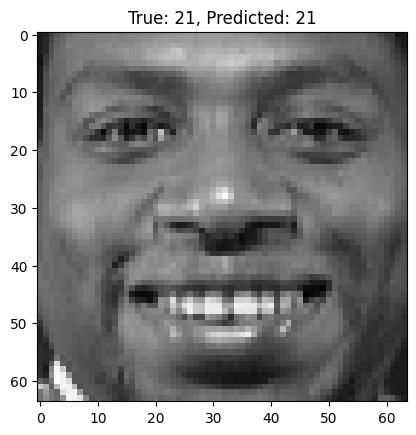

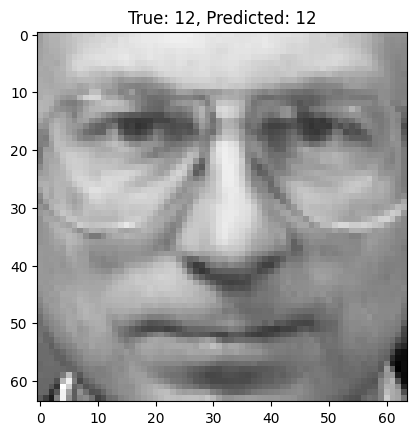

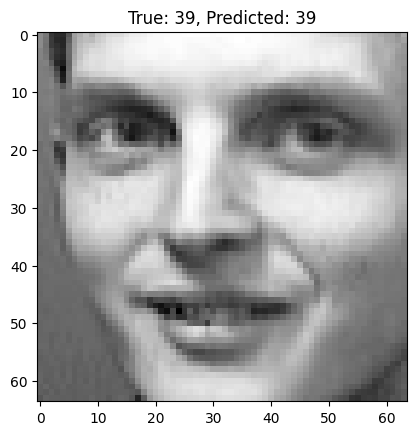

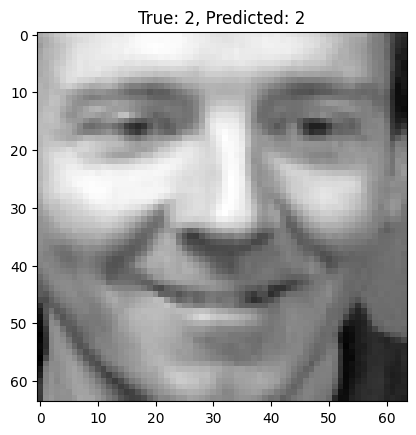

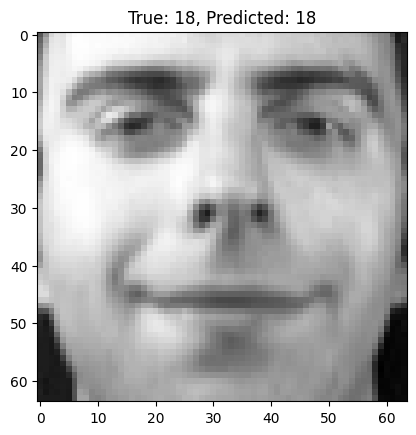

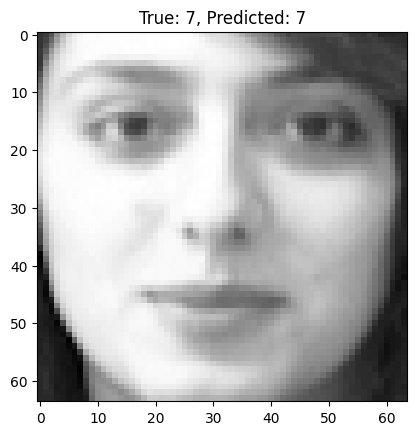

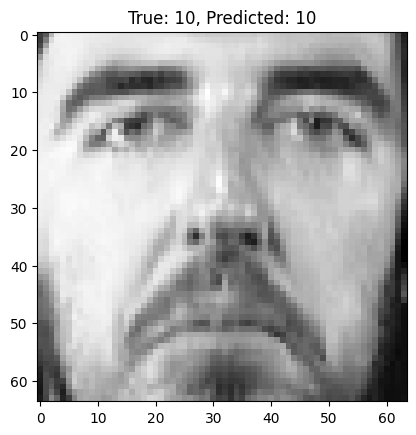

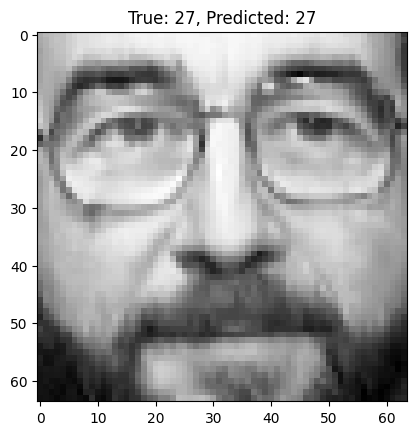

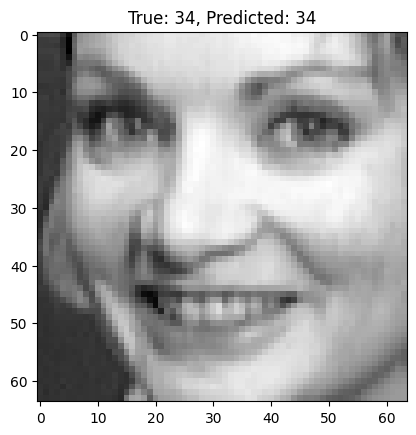

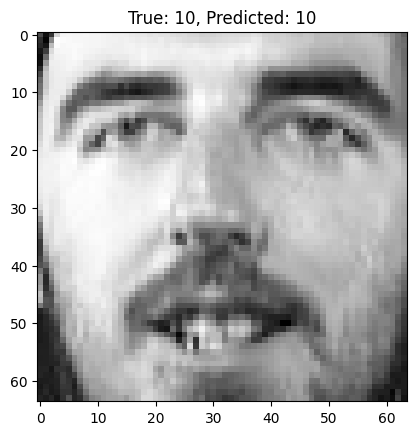

In [153]:
# Evaluation on test set
net.eval()
with torch.no_grad():
    for images_batch, labels_batch in test_dataloader:
        outputs = net(images_batch)
        _, predicted = torch.max(outputs, 1)

        #Print image and prediction
        image = images_batch.squeeze().numpy() #remove channel dimension and convert to numpy.
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {labels_batch.item()}, Predicted: {predicted.item()}")
        plt.show()

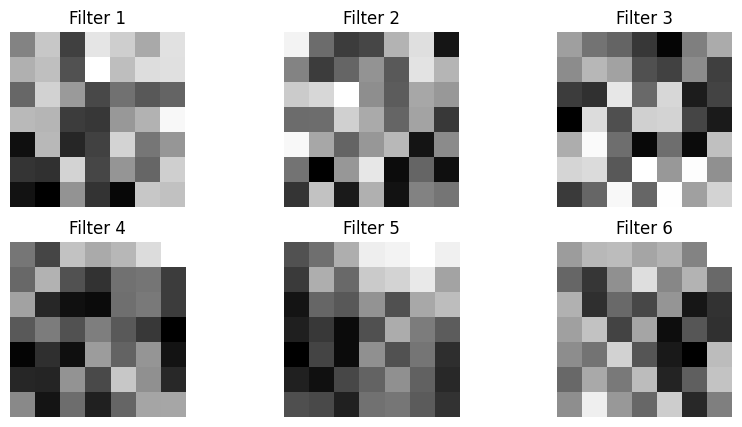

In [154]:
# Lastly, let's visualize the filters of the first layer

# Visualize the filters of the first convolutional layer
filters = net.conv1.weight.detach().numpy() # Get the filters and convert to numpy

num_filters = filters.shape[0]
plt.figure(figsize=(10, 5))

for i in range(num_filters):
    plt.subplot(2, num_filters // 2, i + 1)
    plt.imshow(filters[i, 0, :, :], cmap='gray') # Display the filter
    plt.title(f'Filter {i + 1}')
    plt.axis('off')

plt.show()